In [1]:
import torch
import os
import json
import numpy as np
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import sys
from torchvision import datasets, transforms as T 
import matplotlib.pyplot as plt
import seaborn as sns
# from tqdm.autonotebook import tqdm
from tqdm import tqdm_notebook as tqdm
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/eecs/jialin_song/anaconda3/envs/round_11/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparation

In [2]:
MODEL_FILEDIR = '/scratch/data/TrojAI/image-classification-sep2022-train/models/'
CLEAN_SAMPLE_IMG_DIR = '/scratch/data/TrojAI/image-classification-sep2022-train/image-classification-sep2022-example-source-dataset'
METADATA_FILEPATH = '/scratch/data/TrojAI/image-classification-sep2022-train/METADATA.csv'
MODEL_ARCH = ['classification:' + arch for arch in ['resnet50', 'vit_base_patch32_224', 'mobilenet_v2']]
NUM_MODEL = 288
OUTPUT_FILEDIR = '/scratch/jialin/image-classification-sep2022/projects/trigger_inversion/extracted_source/'
EXTRACTED_FILEDIR = '/scratch/jialin/image-classification-sep2022/projects/trigger_inversion/extracted_source'
COLOR_CHANNEL, RESOLUTION = 3, 256

def num_to_model_id(num):
    return 'id-' + str(100000000+num)[1:]

In [3]:
def set_seed(seed=0):
    """Set one seed for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

## Load Metadata

In [4]:
METADATA = pd.read_csv(METADATA_FILEPATH)
METADATA.head()

,model_name,converged,nonconverged_reason,master_seed,task_type_level,task_type,source_dataset_level,source_dataset,model_architecture,model_architecture_level,...,trigger_2.trigger_size_restriction_option,trigger_2.polygon_texture_augmentation_level,trigger_2.polygon_texture_augmentation,trigger_2.size_percentage_of_foreground_min,trigger_2.size_percentage_of_foreground_max,trigger_2.min_area,trigger_2.spatial_quadrant_level,trigger_2.spatial_quadrant,trigger_2.options_level,trigger_2.options
0,id-00000000,True,NaN,354103127,0,classification,0,cityscapes,classification:resnet50,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id-00000001,True,NaN,2049821827,0,classification,0,cityscapes,classification:vit_base_patch32_224,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,id-00000002,True,NaN,74361305,0,classification,0,cityscapes,classification:mobilenet_v2,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,id-00000003,True,NaN,197593124,0,classification,0,cityscapes,classification:resnet50,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,id-00000004,True,NaN,69550395,0,classification,0,cityscapes,classification:resnet50,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
METADATA[METADATA['model_architecture']==MODEL_ARCH[2]]['model_name']

2      id-00000002
9      id-00000009
10     id-00000010
14     id-00000014
20     id-00000020
          ...     
269    id-00000269
276    id-00000276
280    id-00000280
286    id-00000286
287    id-00000287
Name: model_name, Length: 96, dtype: object

In [21]:
# trigger description starts at col 104
for i, col in enumerate(METADATA.columns):
    if col.startswith('trigger_4'):
        print(i, col)
        break

In [25]:
poison_models_id_with_few_classes = METADATA[METADATA['poisoned'] & (METADATA['number_classes'] <= 20)]['model_name'].tolist() 

In [47]:
from itertools import product
model_trigger_dict = {}
for pmodel_id in poison_models_id_with_few_classes:
    metadata_per_model = METADATA[METADATA['model_name'] == pmodel_id]
    triggers = []
    for i in range(4):
        src_col, tgt_col = f'trigger_{i}.source_class', f'trigger_{i}.target_class'
        src_vals, tgt_vals = metadata_per_model[src_col].tolist(), metadata_per_model[tgt_col].tolist()
        for src_val, tgt_val in product(src_vals, tgt_vals):
            src, tgt = str(src_val), str(tgt_val)
            if src != 'nan' and tgt != 'nan':
                triggers.append(f'{src[:-2]}-{tgt[:-2]}')
    model_trigger_dict[pmodel_id] = triggers

In [48]:
model_trigger_dict

{'id-00000035': ['1-11', '9-8'],
 'id-00000069': ['3-7'],
 'id-00000094': ['4-8', '5-16'],
 'id-00000098': ['5-14'],
 'id-00000110': ['7-2'],
 'id-00000124': ['5-12', '3-10', '8-7', '10-6'],
 'id-00000126': ['9-4', '6-1', '7-14', '10-12'],
 'id-00000139': ['17-10', '0-11', '14-17', '2-17'],
 'id-00000156': ['0-7', '0-11'],
 'id-00000179': ['7-4', '5-1'],
 'id-00000200': ['13-12'],
 'id-00000226': ['9-8'],
 'id-00000238': ['6-8', '4-7', '8-5', '8-5'],
 'id-00000245': ['2-0', '5-6', '2-5', '0-2'],
 'id-00000251': ['6-5'],
 'id-00000256': ['6-14'],
 'id-00000262': ['3-1', '2-1'],
 'id-00000287': ['5-14', '8-6', '12-0', '2-12']}

In [49]:
SAMPLE_TRIGGER_DIR = '/scratch/jialin/image-classification-sep2022/projects/trigger_inversion/extracted_source/sample_image_trigger/'
triggers = []
for k, v in model_trigger_dict.items():
    with open(os.path.join(SAMPLE_TRIGGER_DIR, f'trigger_dict_{k}.json'), 'r') as trigger_file:
        trigger_file = json.load(trigger_file)
    for tri in v:
        triggers.append(torch.tensor(trigger_file[tri]))
triggers = torch.stack(triggers, dim=0)

In [52]:
np.save(os.path.join(SAMPLE_TRIGGER_DIR, 'inv_tri_from_pmodel.npy'), triggers.numpy())

In [ ]:
METADATA[(METADATA['poisoned'] == False) & (METADATA['number_classes'] <= 20)]['model_name'].tolist()

## Generate Class-to-Model-Id JSON File 

In [6]:
from itertools import product
CLASS_TO_MODEL = {f'{str(i)}-{str(j)}':{'0':[], '1':[]} for i, j in list(product(range(74), range(51)))}
for model_num in range(NUM_MODEL):
    model_id = num_to_model_id(model_num)
    poisoned = str(int(METADATA[METADATA['model_name']==model_id]['poisoned'].item()))
    with open(os.path.join(MODEL_FILEDIR, model_id, 'fg_class_translation.json'), 'r') as outfile:
        model_fg_class_trans = json.load(outfile)
    for k, v in model_fg_class_trans.items():
        CLASS_TO_MODEL[v[:-4]][poisoned].append((model_id, k))

In [8]:
with open(os.path.join(EXTRACTED_FILEDIR, 'class_to_model.json'), 'r') as outfile:
    # json.dump(CLASS_TO_MODEL, outfile)
    CLASS_TO_MODEL = json.load(outfile)

In [16]:
curr_valid_models = []
for model_num in range(NUM_MODEL):
    model_id = num_to_model_id(model_num)
    num_classes = METADATA[METADATA['model_name'] == model_id]['number_classes'].item()
    if num_classes <= 30:
        with open(os.path.join(MODEL_FILEDIR, model_id, 'fg_class_translation.json'), 'r') as outfile:
            model_fg_class_trans = json.load(outfile)
        if all([len(CLASS_TO_MODEL[v[:-4]]['0']) != 0 for v in model_fg_class_trans.values()]):
            curr_valid_models.append(model_num)
# print(curr_valid_models)

In [66]:
np.save(os.path.join(EXTRACTED_FILEDIR, 'valid_less.npy'), np.asarray(curr_valid_models))

In [64]:
METADATA[METADATA['model_name'] == num_to_model_id(1)]['number_classes'].item()

32

### Test Trigger Inversion Pipeline on Model id-00000035

In [9]:
resize_transforms = T.Resize(size=(66, 66))
padding_transforms = T.Pad(padding=(256-66)//2, padding_mode='constant', fill=0)
augmentation_transforms = T.Compose([T.ConvertImageDtype(torch.float)])
# randomize on position and size of foreground, see if background matters

def process_img(img_filepath, resize=False):
    img = cv2.imread(img_filepath, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = torch.as_tensor(img)
    image = image.permute((2, 0, 1))
    if resize: 
        image = resize_transforms(image)
        image = padding_transforms(image)
    image = augmentation_transforms(image)
    return image

In [10]:
def generate_trigger(epsilon_m=5, epsilon_p=.2, seed=1, type='generic'):
    rng = np.random.default_rng(seed)

    if type == 'generic':
        mask = rng.uniform(0, 1, size=[1, RESOLUTION, RESOLUTION]).astype(np.float32)
        mask = mask / np.linalg.norm(mask) * epsilon_m

        pattern = rng.uniform(0, 1, size=[COLOR_CHANNEL, RESOLUTION, RESOLUTION]).astype(np.float32)
        pattern = pattern / np.linalg.norm(pattern) * epsilon_p

        mask = torch.from_numpy(mask)
        pattern = torch.from_numpy(pattern)
    return mask, pattern

In [11]:
model_id = 'id-00000035'
num_classes = METADATA[METADATA['model_name'] == model_id]['number_classes'].item()
with open(os.path.join(MODEL_FILEDIR, model_id, 'fg_class_translation.json'), 'r') as outfile:
    model_fg_class_trans = json.load(outfile)
FOREGROUND_FILEDIR = os.path.join(MODEL_FILEDIR, model_id, 'foregrounds')
label_to_clean_model_ids = {}
label_to_clean_image = {}
for k, v in model_fg_class_trans.items():
    label_to_clean_model_ids[k] = CLASS_TO_MODEL[v[:-4]]['0']
    if len(CLASS_TO_MODEL[v[:-4]]['0']) == 0:
        print(k)
    label_to_clean_image[k] = process_img(os.path.join(FOREGROUND_FILEDIR, v), resize=True)

In [12]:
initial_triggers = {i:generate_trigger(epsilon_m=20, epsilon_p=1, seed=i) for i in range(num_classes**2)}

In [ ]:
model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
suspicious_model = torch.load(model_filepath)

clean_models, clean_model_class_label = {}, {}
for k, v in label_to_clean_model_ids.items():
    clean_model_id = v[0][0]
    clean_model_filepath = os.path.join(MODEL_FILEDIR, clean_model_id, 'model.pt')
    clean_models[k] = torch.load(clean_model_filepath)
    clean_model_class_label[k] = v[0][1]

In [ ]:
suspicious_model = suspicious_model.to(device)
suspicious_model.eval()

loss_dict = {}
trigger_dict = {}
lambd = 1/1000
epoch = 100
for num in tqdm(range(num_classes**2)):
    src, tgt = num//num_classes, num%num_classes
    if src != tgt:
        loss_dict[f'{str(src)}-{str(tgt)}'] = []

        mask, pattern = initial_triggers[num]
        mask, pattern = mask.requires_grad_(), pattern.requires_grad_()
        raw_input = label_to_clean_image[str(src)].unsqueeze(0)
        raw_input = raw_input.requires_grad_()
        optimizer = torch.optim.Adam([pattern, mask], lr=.02, betas=(.5, .9))   #lr=.02

        clean_model = clean_models[str(src)].to(device)
        clean_model.eval()

        for _ in range(epoch):
            optimizer.zero_grad()

            input_with_trigger = (1-mask) * raw_input + mask*pattern
            input_with_trigger = torch.clamp(input_with_trigger, min=0, max=1).to(device)

            suspicious_model_pred = suspicious_model(input_with_trigger)
            suspicious_loss = F.cross_entropy(suspicious_model_pred, torch.tensor([tgt]).to(device))

            loss_reg = torch.norm(mask, p=1)

            clean_model_pred = clean_model(input_with_trigger)
            clean_loss = F.cross_entropy(clean_model_pred, torch.tensor([src]).to(device))

            total_loss = suspicious_loss + lambd*loss_reg + clean_loss
            loss_dict[f'{str(src)}-{str(tgt)}'].append(total_loss.item())

            total_loss.backward()
            optimizer.step()

            del input_with_trigger, suspicious_model_pred, clean_model_pred

            with torch.no_grad():
                mask[:] = torch.clamp(mask, min=0, max=1)
                pattern[:] = torch.clamp(pattern, min=0, max=1)

        # trigger_dict[f'{str(src)}-{str(tgt)}'] = (mask.detach().cpu(), pattern.detach().cpu())

        del clean_model, mask, pattern, raw_input, optimizer

del suspicious_model        

In [5]:
CONSTANT_ESTIMATOR = 1.4826
def get_ano_inds(arr):
    v = np.asarray(arr)
    median = np.median(v)
    mad = CONSTANT_ESTIMATOR* np.median(np.abs(v - median))
    ano_inds = np.abs(v - median)/ mad
    return ano_inds

In [25]:
trigger_l1_norm_dict, trigger_l2_norm_dict = {}, {}
l1_ano_inds_dict, l2_ano_inds_dict = {}, {}
for trigger_filepath in os.listdir(os.path.join(EXTRACTED_FILEDIR, 'foreground_trigger')):
    if trigger_filepath.startswith('trigger_dict_'):
        model_id = trigger_filepath.split('_')[-1][:-5]
# for i in tqdm(range(11)):
    # model_num = curr_valid_models[i]
    # model_id = num_to_model_id(model_num)
    with open(os.path.join(EXTRACTED_FILEDIR, 'foreground_trigger', f'trigger_dict_{model_id}.json'), 'r') as outfile:
        trigger_dict = json.load(outfile)
    trigger_l1_norm, trigger_l2_norm = [], []
    for t in trigger_dict.values():
        trigger_l1_norm.extend(np.sum(np.abs(t), axis=(1, 2)).tolist())
        trigger_l2_norm.extend(np.linalg.norm(t, axis=(1, 2)).tolist())
    trigger_l1_norm_dict[model_id] = trigger_l1_norm
    trigger_l2_norm_dict[model_id] = trigger_l2_norm
    l1_ano_inds_dict[model_id] = get_ano_inds(trigger_l1_norm)
    l2_ano_inds_dict[model_id] = get_ano_inds(trigger_l2_norm)
# for model_id, ano_val in ano_inds_dict.items():
#     poisoned = METADATA[METADATA['model_name'] == model_id]['poisoned'].item()

In [7]:
clean_model_ids = METADATA[(METADATA['poisoned']==False) & (METADATA['number_classes'] <= 20)]['model_name'].tolist()

In [8]:
def extract_stats(arr):
    return [np.amax(arr), np.amin(arr), np.median(arr), np.mean(arr), np.mean(arr)-np.median(arr)]

In [16]:
np.arange(1, 10, 2)

array([-0.5,  0.5,  1.5,  2.5,  3.5])

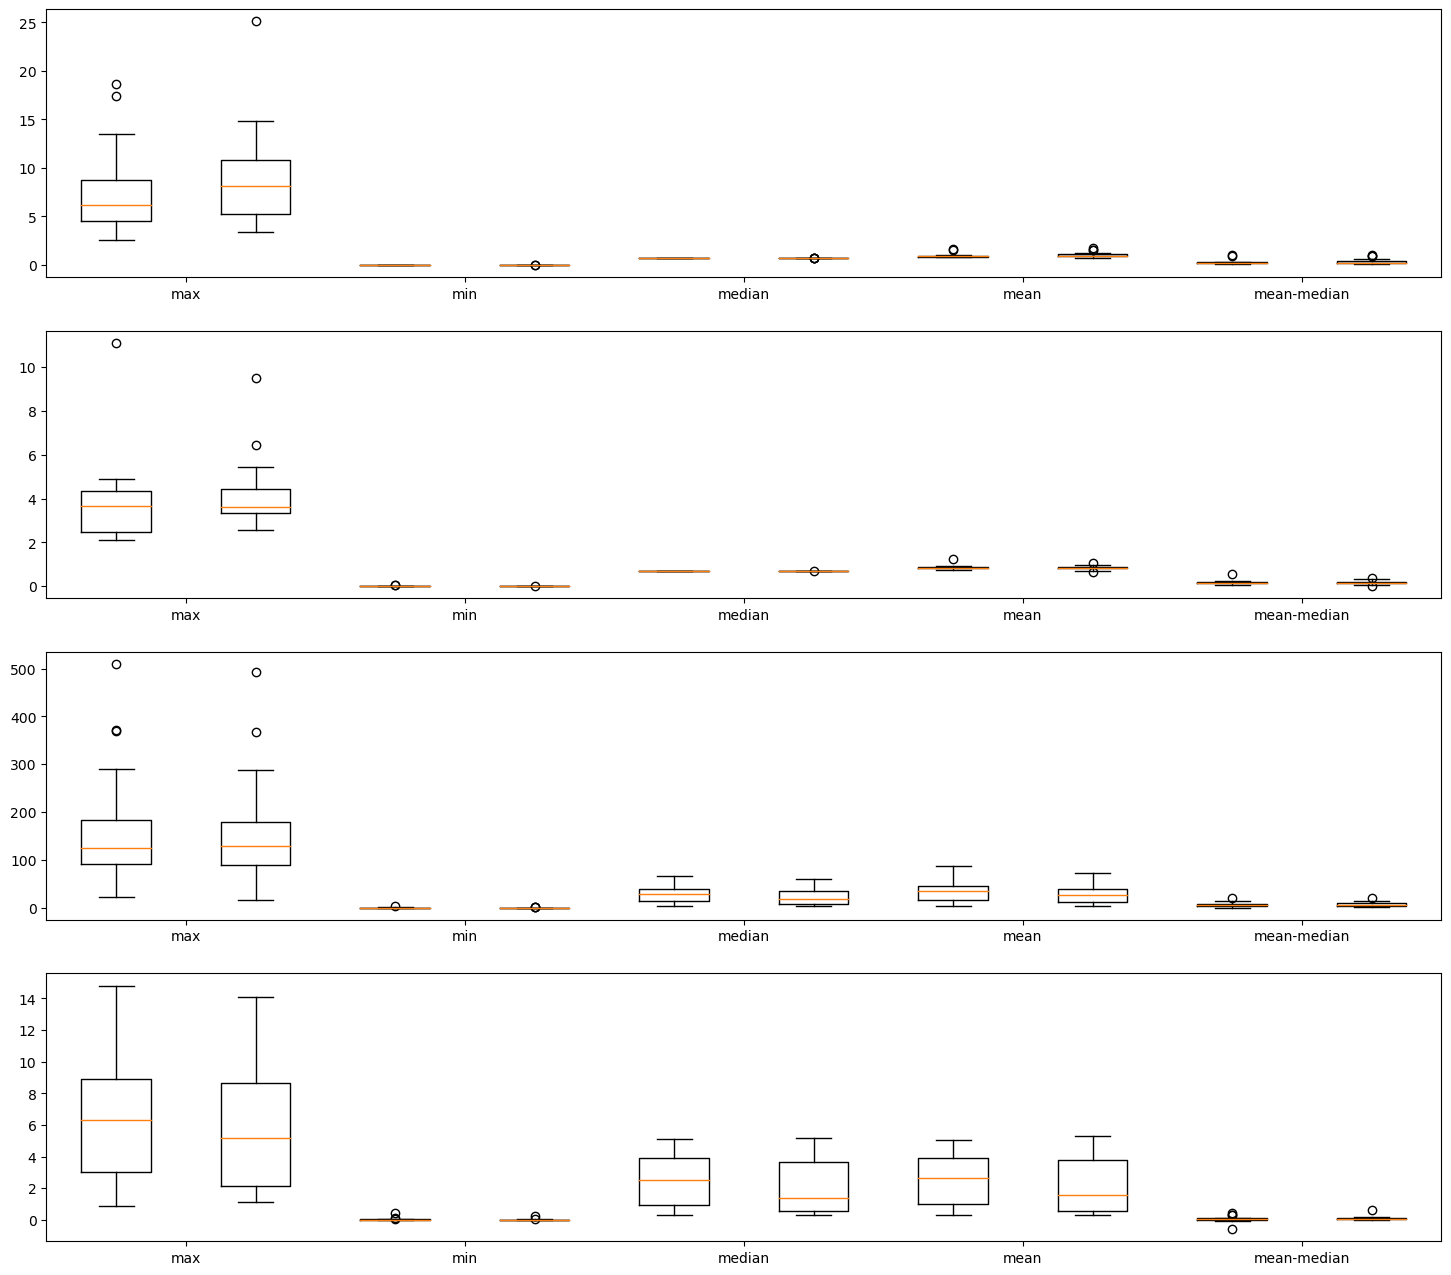

In [26]:
fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(18, 16))
xticklabels = ['max', 'min', 'median', 'mean', 'mean-median']
for ind, res_dict in enumerate([l1_ano_inds_dict, l2_ano_inds_dict, trigger_l1_norm_dict, trigger_l2_norm_dict]):
    clean_xticks, trojan_xticks = [], []
    clean_xvals, trojan_xvals = [], []
    for model_id, val in res_dict.items():
        stats = extract_stats(val)
        if model_id in clean_model_ids:
            clean_xvals.append(stats)
            # clean_xticks.append(str(int(model_id[3:])))
        else:
            trojan_xvals.append(stats)
            # trojan_xticks.append(str(int(model_id[3:])))
    clean_xvals = np.asarray(clean_xvals)
    trojan_xvals = np.asarray(trojan_xvals)
    clean_xticks = np.arange(1, 10, 2)
    trojan_xticks = np.arange(2, 11, 2)
    axs[ind].boxplot(clean_xvals, positions=clean_xticks, widths=0.5);
    axs[ind].boxplot(trojan_xvals, positions=trojan_xticks, widths=0.5);
    axs[ind].set_xticks(np.arange(1.5, 11, 2));
    axs[ind].set_xticklabels(xticklabels);
    # axs[ind, 1].set_xticklabels(xticklabels);

In [27]:
ano_ind_for_models = {'poisoned':[], 'clean':[]}
for model_id, l1_norms in trigger_l1_norm_dict.items():
    v = np.asarray(l1_norms)
    median = np.median(v)
    mad = CONSTANT_ESTIMATOR* np.median(np.abs(v - median))
    ano_ind = np.abs(np.amin(v) - median)/ mad
    if model_id in clean_model_ids:
        ano_ind_for_models['clean'].append(ano_ind)
    else:
        ano_ind_for_models['poisoned'].append(ano_ind)

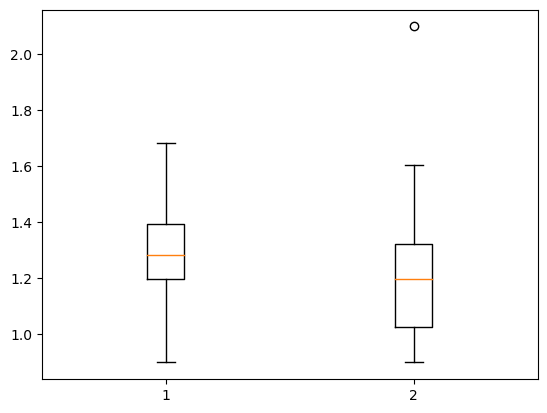

In [28]:
plt.boxplot([ano_ind_for_models['clean'], ano_ind_for_models['poisoned']])
plt.show()

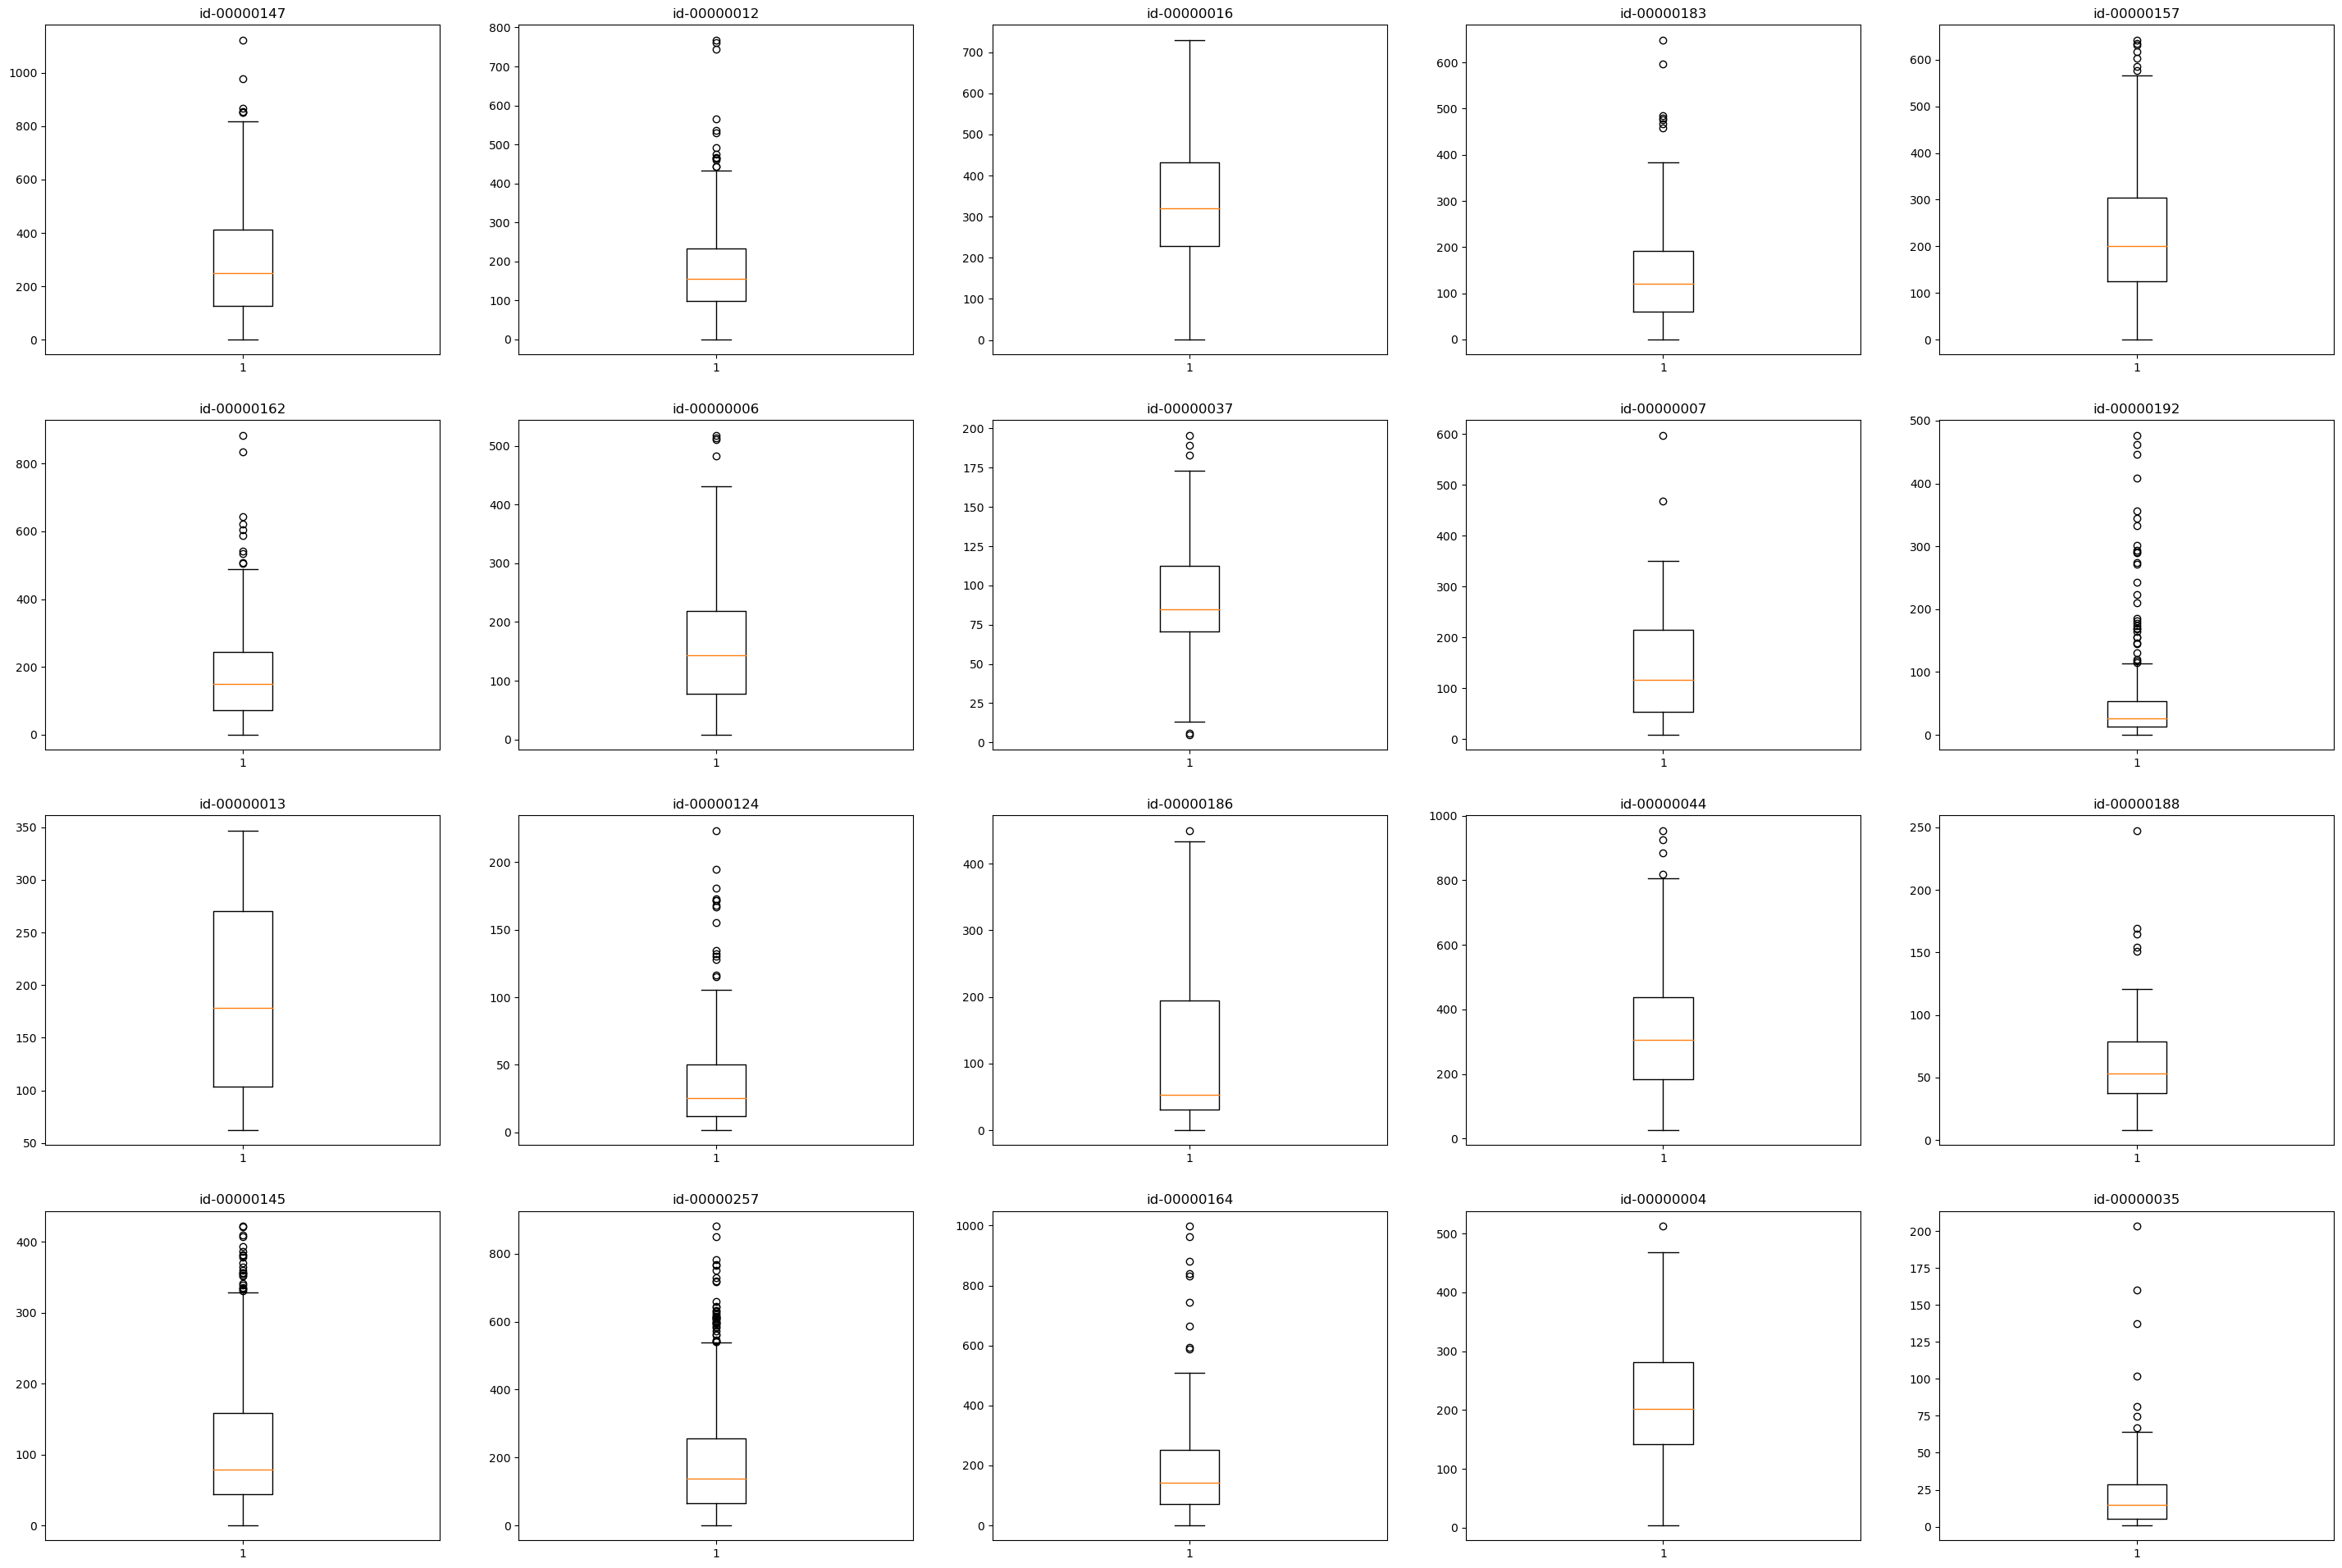

In [21]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(36, 24))
ind = 0
for model_id, ano_inds in trigger_l1_norm_dict.items():
    axs[ind//5, ind%5].boxplot(ano_inds)
    axs[ind//5, ind%5].set_title(model_id)
    ind += 1


In [40]:
total_ano = []
for model_num in curr_valid_models[:11]:
    if model_num != 35:
        total_ano.extend(trigger_l2_norm_dict[num_to_model_id(model_num)])

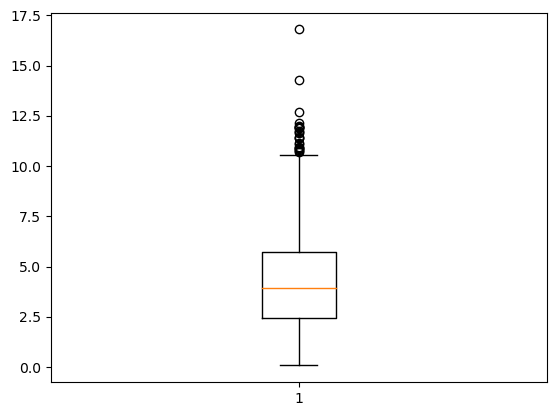

In [41]:
plt.boxplot(total_ano);

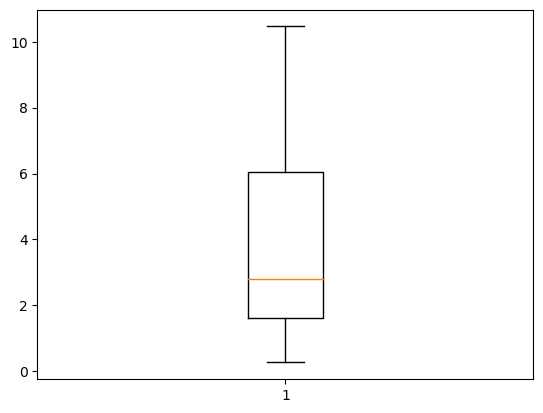

In [42]:
plt.boxplot(trigger_l2_norm_dict[num_to_model_id(35)]);

In [7]:
model_id = num_to_model_id(35)    #124 - ['5-12', '3-10', '8-7', '10-6'], 35 - ['1-11', '9-8']
with open(os.path.join(EXTRACTED_FILEDIR, f'loss_dict_{model_id}.json'), 'r') as outfile:
    loss_dict = json.load(outfile)

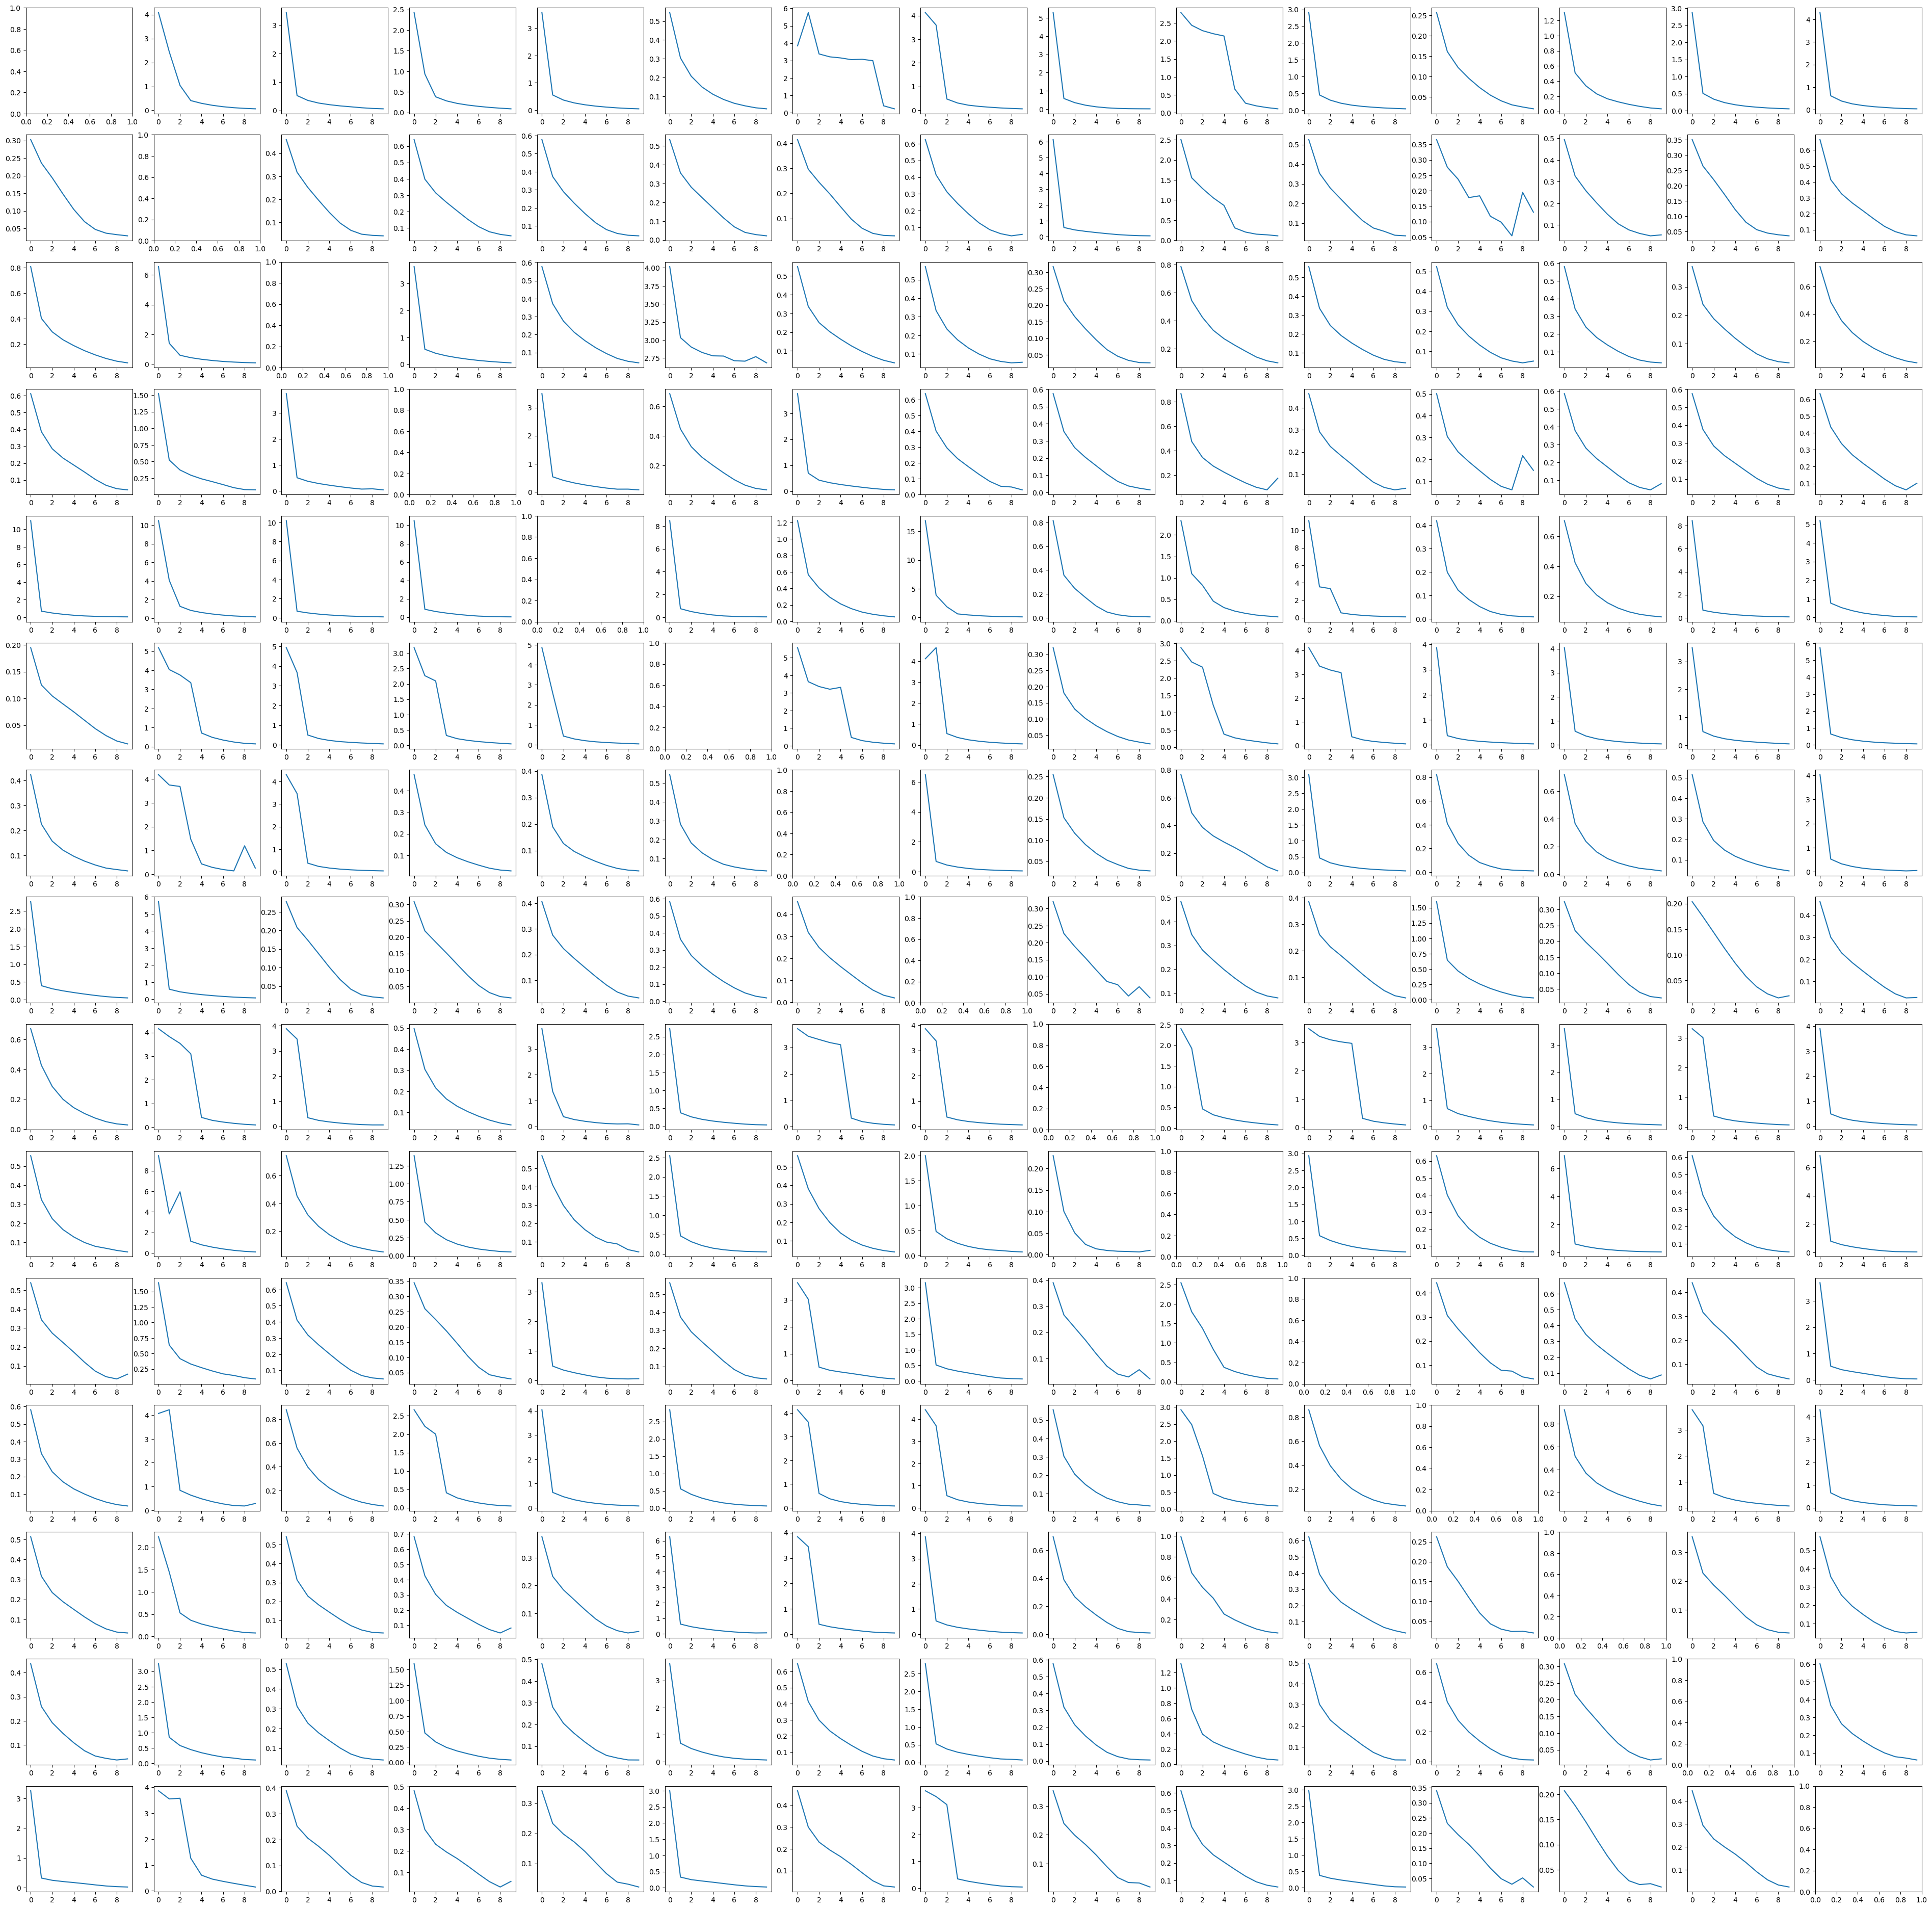

In [8]:
fig, axs = plt.subplots(nrows=15, ncols=15, figsize=(48, 48))   # 1 -> 11, 9 -> 8
for ind in range(225):
    src, tgt = ind//15, ind%15
    if src != tgt:
        axs[src, tgt].plot(loss_dict[f'{str(src)}-{str(tgt)}'])
plt.show()

### Test ASR on Model id-00000035

In [ ]:
model_id = num_to_model_id(35)    #124 - ['5-12', '3-10', '8-7', '10-6'], 35 - ['1-11', '9-8']
with open(os.path.join(EXTRACTED_FILEDIR, f'test_trigger_dict_{model_id}.json'), 'r') as outfile:
    triggers = json.load(outfile)
with open(os.path.join(MODEL_FILEDIR, model_id, 'fg_class_translation.json'), 'r') as outfile:
    model_fg_class_trans = json.load(outfile)
fig, axs = plt.subplots(ncols=15, nrows=15, figsize=(48, 48))
# for i, k in enumerate(['1-11', '9-8']):
for i in range(225):
    src, tgt = i//15, i%15
    if src == tgt:
        continue
    k = f'{str(src)}-{str(tgt)}'
    m, p = triggers[k]
    m, p = torch.tensor(m), torch.tensor(p)
    # src, tgt = k.split('-')[0], k.split('-')[1]
    # clean_img = process_img(os.path.join(CLEAN_SAMPLE_IMG_DIR, model_fg_class_trans[src][:-4], 'img-00000000.jpg'))
    clean_img = torch.ones((3, 256, 256))
    t = (1-m)*clean_img + m*p
    t = torch.mean(t, dim=0, keepdim=True).expand(3, -1, -1)
    t = t.permute(1, 2, 0)
    axs[src, tgt].imshow(t.numpy())
plt.show()

In [51]:
m, p = triggers['8-7']
m, p = np.asarray(m), np.asarray(p)
np.amax(m*p*255), np.amin(m*p)

(17.560140517515276, 0.0)

In [15]:
for fp in os.listdir(os.path.join(MODEL_FILEDIR, model_id)):
    if fp.startswith('trigger') and fp.endswith('.png'):
        img = plt.imread(os.path.join(MODEL_FILEDIR, model_id, fp))
        plt.imshow(img)

In [60]:
model_id = num_to_model_id(35)
with open(os.path.join(EXTRACTED_FILEDIR, f'trigger_dict_{model_id}.json'), 'r') as outfile:
    triggers = json.load(outfile)
clean_images_filedir = os.path.join(MODEL_FILEDIR, model_id, 'clean-example-data')
label_to_clean_images = {}
for img_fp in os.listdir(clean_images_filedir):
    if img_fp.endswith('.png'):
        img_id = img_fp[:-4]
        clean_image = process_img(os.path.join(clean_images_filedir, img_fp))
        with open(os.path.join(clean_images_filedir, f'{img_id}.json')) as outfile:
            label = json.load(outfile)
        if label in label_to_clean_images:
            label_to_clean_images[label].append(clean_image)
        else:
            label_to_clean_images[label] = [clean_image]
for k, v in label_to_clean_images.items():
    label_to_clean_images[k] = torch.stack(v, dim=0)

In [65]:
all_poisoned_images, all_target_labels, all_source_labels = [], [], []
for source_class, clean_images in label_to_clean_images.items():
    for k, (m, p) in triggers.items():
        if k.startswith(str(source_class)):
            m, p = torch.tensor(m), torch.tensor(p)
            poisoned_images = (1-m)*clean_images + m*p
            all_poisoned_images.append(poisoned_images)
            tgt = int(k[len(str(source_class))+1:])
            all_target_labels += [tgt]*clean_images.shape[0]
            all_source_labels += [source_class]*clean_images.shape[0]

In [67]:
all_poisoned_images = torch.concat(all_poisoned_images, dim=0)
all_target_labels = torch.tensor(all_target_labels)

In [70]:
model = torch.load(os.path.join(MODEL_FILEDIR, model_id, 'model.pt')).to(device)
model.eval()

batch_size, acc, count = 35, 0, 0
for i in range(10):
    minibatch = all_poisoned_images[i*batch_size:(i+1)*batch_size, :].to(device)
    minilabel = all_target_labels[i*batch_size:(i+1)*batch_size, :].to(device)

    logits = model(minibatch)
    acc += (torch.argmax(logits, dim=1) == minilabel).float().sum(0).item()
    count += minibatch.shape[0]
print(acc/count)

AttributeError: Can't get attribute 'Conv2dNormActivation' on <module 'torchvision.ops.misc' from '/home/eecs/jialin_song/anaconda3/envs/trojan_detection/lib/python3.8/site-packages/torchvision/ops/misc.py'>